### Imports

In [95]:
import os
import sys
import pathlib
import numpy as np

from pymdp.agent import Agent
from pymdp import utils, maths

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

## Grid World Parameters

In [96]:
grid_dims       = [4, 3]
num_grid_points = np.prod(grid_dims)

grid = np.arange(num_grid_points).reshape(grid_dims)
it = np.nditer(grid, flags=["multi_index"])

loc_list = []
while not it.finished:
    loc_list.append(it.multi_index)
    it.iternext()

clue_location = (3, 1)

reward_conditions = ["TOP", "BOTTOM"]
reward_locations = [(0, 2), (3, 2)]


### Visualize the grid world


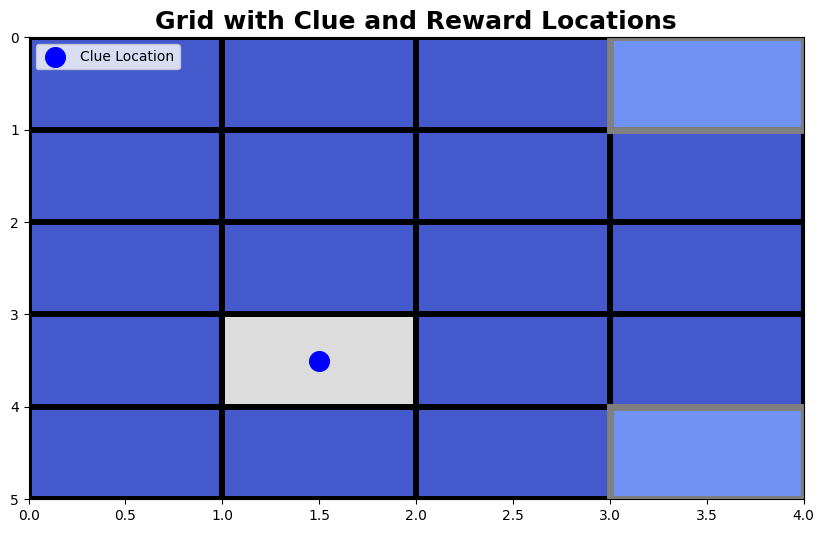

In [97]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create the grid visualization
X, Y = np.meshgrid(np.arange(grid_dims[1] + 1), np.arange(grid_dims[0] + 1))
h = ax.pcolormesh(X, Y, np.ones(grid_dims), edgecolors='k', vmin=0, vmax=30, linewidth=3, cmap='coolwarm')
ax.invert_yaxis()

# Put gray boxes around the possible reward locations
reward_top = ax.add_patch(patches.Rectangle((reward_locations[0][1], reward_locations[0][0]), 1.0, 1.0, linewidth=5, edgecolor='gray', facecolor='none'))
reward_bottom = ax.add_patch(patches.Rectangle((reward_locations[1][1], reward_locations[1][0]), 1.0, 1.0, linewidth=5, edgecolor='gray', facecolor='none'))

text_offsets = [0.4, 0.6]

clue_grid = np.ones(grid_dims)
clue_grid[clue_location[0], clue_location[1]] = 15.0

# Highlight the clue and reward locations
for ii, loc_ii in enumerate(reward_locations):
    row_coord, column_coord = loc_ii
    clue_grid[row_coord, column_coord] = 5.0
    ax.text(column_coord + text_offsets[0], row_coord + text_offsets[1], "", fontsize=15, color='k', fontweight='bold')

# Update the color map array
h.set_array(clue_grid.ravel())

# Improve grid and text appearance
# for (i, j), val in np.ndenumerate(grid):
#     ax.text(j + 0.5, i + 0.5, f'{i},{j}', ha='center', va='center', color='black', fontsize=12)

# Plot the clue location
ax.scatter(clue_location[1] + 0.5, clue_location[0] + 0.5, color='blue', s=200, label="Clue Location", zorder=5)

# Add a legend
plt.legend()
plt.title("Grid with Clue and Reward Locations", fontsize=18, fontweight='bold')
plt.show()

def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()



### The observation model: **A** array

In [98]:
num_states      = [num_grid_points, len(reward_conditions)]

clue_names      = ['Null', 'reward_on_top', 'reward_on_bottom']
reward_names    = ['Null', 'Cheese', 'Shock']

num_obs         = [num_grid_points, len(clue_names), len(reward_names)]

In [99]:
A_m_shapes = [ [o_dim] + num_states for o_dim in num_obs]
A = utils.obj_array_zeros(A_m_shapes)

# A[0] = np.tile(np.expand_dims(np.eye(num_grid_points), (-2, -1)), (1, 1, num_states[0]))
A[0][:, :, 0] = np.eye(num_grid_points, num_grid_points)
A[0][:, :, 1] = np.eye(num_grid_points, num_grid_points)


# Clue observation
A[1][0,:,:] = 1.0

for i, reward_loc in enumerate(reward_locations):
    
    A[1][0,loc_list.index(clue_location),i] = 0.0
    A[1][i+1,loc_list.index(clue_location),i] = 1.0

# make the reward observation depend on the location (being at reward location) and the reward condition
A[2][0,:,:] = 1.0

rew_top_idx = loc_list.index(reward_locations[0]) # linear index of the location of the "TOP" reward location
rew_bott_idx = loc_list.index(reward_locations[1]) # linear index of the location of the "BOTTOM" reward location

# fill out the contingencies when the agent is in the "TOP" reward location
A[2][0,rew_top_idx,:] = 0.0
A[2][1,rew_top_idx,0] = 1.0
A[2][2,rew_top_idx,1] = 1.0

# fill out the contingencies when the agent is in the "BOTTOM" reward location
A[2][0,rew_bott_idx,:] = 0.0
A[2][1,rew_bott_idx,1] = 1.0
A[2][2,rew_bott_idx,0] = 1.0

### The transition model: **B** array

In [100]:
# initialize `num_controls`
num_controls = [5, 1, 1]

# initialize the shapes of each sub-array `B[f]`
B_f_shapes = [ [ns, ns, num_controls[f]] for f, ns in enumerate(num_states)]

# create the `B` array and fill it out
B = utils.obj_array_zeros(B_f_shapes)

Fill out `B[0]` according to the expected consequences of each of the 5 actions. Note that we also create a list that stores the names of each action, for interpretability.

In [101]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

# fill out `B[0]` using the 
for action_id, action_label in enumerate(actions):

  for curr_state, grid_location in enumerate(loc_list):

    y, x = grid_location

    if action_label == "UP":
      next_y = y - 1 if y > 0 else y 
      next_x = x
    elif action_label == "DOWN":
      next_y = y + 1 if y < (grid_dims[0]-1) else y 
      next_x = x
    elif action_label == "LEFT":
      next_x = x - 1 if x > 0 else x 
      next_y = y
    elif action_label == "RIGHT":
      next_x = x + 1 if x < (grid_dims[1]-1) else x 
      next_y = y
    elif action_label == "STAY":
      next_x = x
      next_y = y

    new_location = (next_y, next_x)
    next_state = loc_list.index(new_location)
    B[0][next_state, curr_state, action_id] = 1.0

B[1][:,:,0] = np.eye(num_states[1])
# B[2][:,:,0] = np.eye(num_states[2])

### Prior preferences: the **C** vectors

In [102]:
C = utils.obj_array_zeros(num_obs)

C[2][1] = 2.0 # make the agent want to encounter the "Cheese" observation level
C[2][2] = -4.0 # make the agent not want to encounter the "Shock" observation level

### Prior over (initial) hidden states: the **D** vectors

In [103]:
D = utils.obj_array_uniform(num_states)
D[0] = utils.onehot(loc_list.index((0,0)), num_grid_points)

## Generative process

### Writing a custom `env` 

In [104]:
class GridWorldEnv():
    
    def __init__(self,starting_loc = (0,0), clue_loc = (2, 0), reward_condition = 'TOP'):

        self.init_loc = starting_loc
        self.current_location = self.init_loc

        self.clue_loc = clue_loc

        self.reward_condition = reward_condition
        print(f'Starting location is {self.init_loc}, Reward condition is {self.reward_condition}')
    
    def step(self,action_label):

        (Y, X) = self.current_location

        if action_label == "UP": 
          
          Y_new = Y - 1 if Y > 0 else Y
          X_new = X

        elif action_label == "DOWN": 

          Y_new = Y + 1 if Y < (grid_dims[0]-1) else Y
          X_new = X

        elif action_label == "LEFT": 
          Y_new = Y
          X_new = X - 1 if X > 0 else X

        elif action_label == "RIGHT": 
          Y_new = Y
          X_new = X +1 if X < (grid_dims[1]-1) else X

        elif action_label == "STAY":
          Y_new, X_new = Y, X 
        
        self.current_location = (Y_new, X_new) # store the new grid location

        loc_obs = self.current_location # agent always directly observes the grid location they're in 

        if self.current_location == self.clue_loc:
          clue_obs = clue_names[reward_conditions.index(self.reward_condition)+1]
        else:
          clue_obs = 'Null'
        
        # @NOTE: here we use the same variable `reward_locations` to create both the agent's generative model (the `A` matrix) as well as the generative process. 
        # This is just for simplicity, but it's not necessary -  you could have the agent believe that the Cheese/Shock are actually stored in arbitrary, incorrect locations.

        if self.current_location == reward_locations[0]:
          if self.reward_condition == 'TOP':
            reward_obs = 'Cheese'
          else:
            reward_obs = 'Shock'
        elif self.current_location == reward_locations[1]:
          if self.reward_condition == 'BOTTOM':
            reward_obs = 'Cheese'
          else:
            reward_obs = 'Shock'
        else:
          reward_obs = 'Null'

        return loc_obs, clue_obs, reward_obs

    def reset(self):
        self.current_location = self.init_loc
        print(f'Re-initialized location to {self.init_loc}')
        loc_obs = self.current_location
        clue_obs = 'Null'
        reward_obs = 'Null'

        return loc_obs, clue_obs, reward_obs

## Active Inference


### Initialize an `Agent` and an instance of `GridWorldEnv`

In [105]:
my_agent = Agent(A = A, B = B, C = C, D = D, policy_len = 4)

print(A[0].shape)

my_env = GridWorldEnv(starting_loc = (0,0), clue_loc = clue_location, reward_condition = 'TOP')

loc_obs, clue_obs, reward_obs = my_env.reset()

(20, 20, 2)
Starting location is (0, 0), Reward condition is TOP
Re-initialized location to (0, 0)


### Run an active inference loop over time

In [106]:
history_of_locs = [loc_obs]
obs = [loc_list.index(loc_obs), clue_names.index(clue_obs), reward_names.index(reward_obs)]

T = 10 # number of total timesteps

for t in range(T):

    qs = my_agent.infer_states(obs)

    # plot_beliefs(qs[1])
    
    my_agent.infer_policies()
    chosen_action_id = my_agent.sample_action()

    movement_id = int(chosen_action_id[0])

    choice_action = actions[movement_id]

    # print(f'Action at time {t}: {choice_action}')

    loc_obs, clue_obs, reward_obs = my_env.step(choice_action)

    obs = [loc_list.index(loc_obs), clue_names.index(clue_obs), reward_names.index(reward_obs)]

    history_of_locs.append(loc_obs)

    # print(f'Grid location at time {t}: {loc_obs}')

    # print(f'Clue Obs {t}: {clue_obs}')

    # print(f'Reward at time {t}: {reward_obs}')


### Visualization

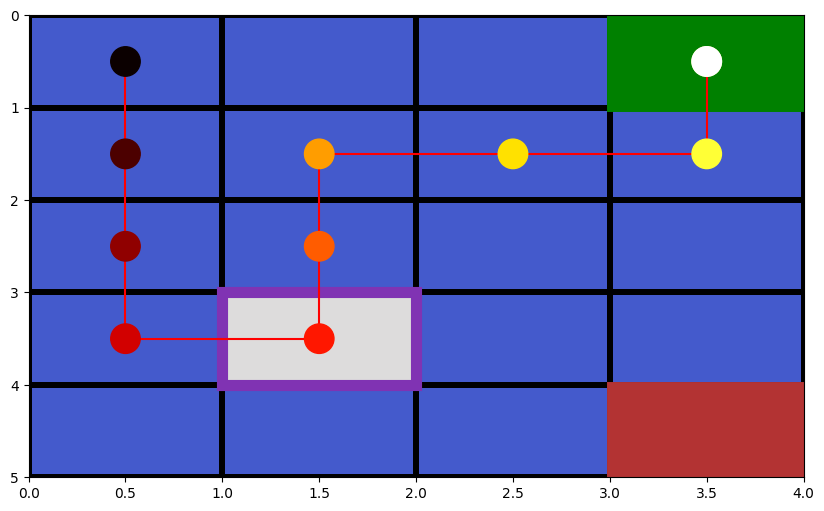

In [107]:
all_locations = np.vstack(history_of_locs).astype(float) # create a matrix containing the agent's Y/X locations over time (each coordinate in one row of the matrix)

fig, ax = plt.subplots(figsize=(10, 6)) 

# create the grid visualization
X, Y = np.meshgrid(np.arange(grid_dims[1]+1), np.arange(grid_dims[0]+1))
h = ax.pcolormesh(X, Y, np.ones(grid_dims), edgecolors='k', vmin = 0, vmax = 30, linewidth=3, cmap = 'coolwarm')
ax.invert_yaxis()

clue_loc, reward_condition = my_env.clue_loc, my_env.reward_condition
reward_top = ax.add_patch(patches.Rectangle((reward_locations[0][1],reward_locations[0][0]),1.0,1.0,linewidth=5,edgecolor=[0.5, 0.5, 0.5],facecolor='none'))
reward_bottom = ax.add_patch(patches.Rectangle((reward_locations[1][1],reward_locations[1][0]),1.0,1.0,linewidth=5,edgecolor=[0.5, 0.5, 0.5],facecolor='none'))
reward_loc = reward_locations[0] if reward_condition == "TOP" else reward_locations[1]

if reward_condition == "TOP":
    reward_top.set_edgecolor('g')
    reward_top.set_facecolor('g')
    reward_bottom.set_edgecolor([0.7, 0.2, 0.2])
    reward_bottom.set_facecolor([0.7, 0.2, 0.2])
elif reward_condition == "BOTTOM":
    reward_bottom.set_edgecolor('g')
    reward_bottom.set_facecolor('g')
    reward_top.set_edgecolor([0.7, 0.2, 0.2])
    reward_top.set_facecolor([0.7, 0.2, 0.2])
reward_top.set_zorder(1)
reward_bottom.set_zorder(1)

text_offsets = [0.4, 0.6]
clue_grid = np.ones(grid_dims)
clue_grid[clue_loc[0],clue_loc[1]] = 15.0
  
h.set_array(clue_grid.ravel())

cue1_rect = ax.add_patch(patches.Rectangle((clue_loc[1],clue_loc[0]),1.0,1.0,linewidth=8,edgecolor=[0.5, 0.2, 0.7],facecolor='none'))

ax.plot(all_locations[:,1]+0.5,all_locations[:,0]+0.5, 'r', zorder = 2)

temporal_colormap = cm.hot(np.linspace(0,1,T+1))
dots = ax.scatter(all_locations[:,1]+0.5,all_locations[:,0]+0.5, 450, c = temporal_colormap, zorder=3)
